In [1]:
from scipy.spatial import Delaunay
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import cm
import time
from tvtk.api import tvtk

In [2]:
# import selfmade utils
from synthdata_utils import grid_torus
from makemesh_indices import make_parammesh_vtk_indices, from_indices_to_paramvals

In [3]:
grid1 = grid_torus(ngrid_cart = 20, ngrid_tor = 20, R0 = 2)

In [4]:
"""
Define some potential that is easy to interpret. Just to have some values to interpolate from.
"""

def testpot(r):
    return np.exp(-r)

tpot_tor = testpot(r = grid1.R)

tpot_cart = testpot(r = np.sqrt((np.sqrt(grid1.cart_x**2 + grid1.cart_y**2) - 2)**2 + grid1.cart_z**2))

In [5]:
dimgrid = list([x for x in grid1.tor_x.shape[::-1]])
sgrid1 = tvtk.StructuredGrid(dimensions=dimgrid)
sgrid1.points = grid1.torflat
sgrid1.point_data.scalars = tpot_tor.ravel()
sgrid1.point_data.scalars.name = "Radial_field"

In [34]:
def func1(*args, **kwargs):
    print([arg for arg in args])
    for key in kwargs:
        print(type(key))

func1(1,2,3, r = 1)

[1, 2, 3]
<class 'str'>


In [37]:
str1 = 'tpot_alldir'
print(str1[:11])

tpot_alldir


In [110]:
"""
Use MMS to confirm that error of grid converges as you increase the number of gridpoints.
Strategy:
1. Establish all grids with increasing number of points in the cartesian grid.
2. Calculate the interpolation
3. Compare potential values with the direct solution on the cartesian grid and compute a 1D measure of the error.
4. Plot error in loglog and see if the error converges.

"""
def MMS_gridres(npnts = 5, init_res = 50, **kwargs):
    tik = time.time()

    gridlist = []
    tpot_cartlist = []
    tpot_torlist = []
    ngridlist = []
    for i in range(npnts):
        gridlist.append( grid_torus(ngrid_cart = init_res, ngrid_tor = init_res*(i+1), R0 = 2) )
        ngridlist.append(gridlist[i].tor_x.shape)
        for key in kwargs:
            if key == 'func1':
                r_tpot = np.sqrt((np.sqrt(gridlist[i].cart_x**2 + gridlist[i].cart_y**2) - 2)**2 + gridlist[i].cart_z**2)
                tpot_cartlist.append( kwargs[key](r = r_tpot ) )
                tpot_torlist.append( kwargs[key](r = gridlist[i].R) )
            elif key == 'func2_1':
                tpot_cartlist.append( kwargs[key](gridlist[i] ) )
            elif key == 'func2_2':
                tpot_torlist.append( kwargs[key](gridlist[i]) )
                    
    ngridlist = np.array(ngridlist)

    sgrid_list = []
    potmesh_vtk_list = []
    runtimelist = []
    for i in range(len(gridlist)):
        print("iteration #", i)
        sgrid_list.append(tvtk.StructuredGrid(dimensions=gridlist[i].tor_x.shape[::-1]))
        sgrid_list[i].points = gridlist[i].torflat
        idxs, ws = make_parammesh_vtk_indices(grid_obj = gridlist[i],sgrid = sgrid_list[i],sp = (0,0,0))
        parammesh = from_indices_to_paramvals(idxs=idxs, weights=ws, param_torgrid=tpot_torlist[i])
        potmesh_vtk_list.append( parammesh )
        tok = time.time()
        runtimelist.append(tok-tik)
    return potmesh_vtk_list, tpot_cartlist, ngridlist, runtimelist

In [58]:
potmesh_vtk_list, tpot_cartlist, ngridlist, runtimelist = MMS_gridres(func1 = testpot)

iteration # 0
1e-08
guessing startpoint
guessing startpoint
iteration # 1
1e-08
guessing startpoint
guessing startpoint
iteration # 2
1e-08
guessing startpoint
iteration # 3
1e-08
guessing startpoint
guessing startpoint
guessing startpoint
iteration # 4
1e-08
guessing startpoint
guessing startpoint


In [99]:
"""
Use the l2norm of the difference between the analytical solution and the interpolated solution
as the measure of error related to the resolution of the grid.
"""

def calc_l2_norm(field):
    normconst = np.prod(field.shape)**(3/2)
    return np.sqrt(np.nansum(field**2))/normconst

l2s = np.zeros((len(potmesh_vtk_list),3))
for i in range(len(l2s)):
    for j in range(l2s.shape[1]):
        l2s[i,j] = calc_l2_norm(field = potmesh_vtk_list[i] - tpot_cartlist[i])


print(l2s[:,0])
print(l2s[:,1])
print(l2s[:,2])

[1.86397538e-08 4.51978916e-09 1.98288108e-09 1.10692948e-09
 7.37884369e-10]
[1.86397538e-08 4.51978916e-09 1.98288108e-09 1.10692948e-09
 7.37884369e-10]
[1.86397538e-08 4.51978916e-09 1.98288108e-09 1.10692948e-09
 7.37884369e-10]


In [100]:
ngridlist[:,0]

array([ 50, 100, 150, 200, 250])

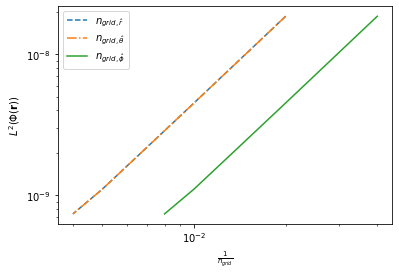

In [101]:
# make a list over the grid resolution

plt.figure()
plt.plot(1/ngridlist[:,0], l2s[:,0], '--',label = "$n_{grid, \\hat{r}}$")
plt.plot(1/ngridlist[:,1], l2s[:,1], '-.',label = "$n_{grid, \\hat{\\theta}}$")
plt.plot(1/ngridlist[:,2], l2s[:,2], '-',label = "$n_{grid, \\hat{\\phi}}$")
plt.xlabel("$\\frac{1}{n_{grid}}$")
plt.ylabel("$L^2(\\Phi(\\mathbf{r}))$")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [97]:
#%%writefile expofit.py
"""
Do exponential fit the gridscaling data compared with the l2 norm.
"""
def expofit(ngx, ngy, ngz, l2list):
    """
    Do exponential fit of the change in gridpoint res compared to l2 of the noise of a scalar field.
    Args:
    - ngx, array np.int32, array of grid res along x axis
    - ngy, array np.int32, array of grid res along y axis
    - ngz, array np.int32, array of grid res along z axis
    - l2list, array of np.float64, array of l2 norms for different resolutions
    Out:
    - None, plots the exponential fit.
    """
    import numpy as np
    from matplotlib import pyplot as plt
    ax, bx = np.polyfit(np.log(1/ngx), np.log(l2list[:,0]), 1, w=np.sqrt(l2list[:,0]))
    ay, by = np.polyfit(np.log(1/ngy), np.log(l2list[:,1]), 1, w=np.sqrt(l2list[:,1]))
    az, bz = np.polyfit(np.log(1/ngz), np.log(l2list[:,2]), 1, w=np.sqrt(l2list[:,2]))
    
    plt.figure()
    plt.plot(1/ngx, l2list[:,0], '--o',label = "$n_{grid, \\hat{r}}$")
    plt.plot(1/ngy, l2list[:,1], '-o',label = "$n_{grid, \\hat{\\theta}}$")
    plt.plot(1/ngz, l2list[:,2], '-x',label = "$n_{grid, \\hat{\\phi}}$")
    plt.plot(1/ngx, np.exp(ax*np.log(1/ngx) + bx), '--',label = "$\\approx n_{grid, \\hat{r}}$")
    plt.plot(1/ngy, np.exp(ay*np.log(1/ngy) + by), '-.',label = "$\\approx n_{grid, \\hat{\\theta}}$")
    plt.plot(1/ngz, np.exp(az*np.log(1/ngz) + bz), '-',label = "$\\approx n_{grid, \\hat{\\phi}}$")
    plt.xlabel("$\\frac{1}{n_{grid}}$")
    plt.ylabel("$L^2(\\Phi(\\mathbf{r}))$")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.show()

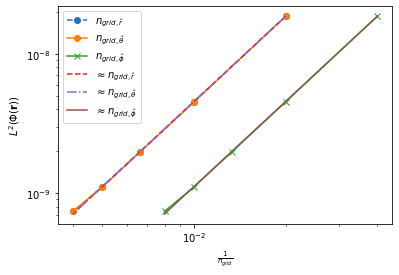

In [102]:
#from expofit import expofit
expofit(ngx = ngridlist[:,0], ngy = ngridlist[:,1], ngz = ngridlist[:,2], l2list = l2s)

In [118]:
"""
Now define a potential which varies in all directions. The potential varies periodically in theta and phi direction.
"""
def tpot_alldir_cart(grid_obj):
    r = np.sqrt((np.sqrt(grid_obj.cart_x**2 + grid_obj.cart_y**2) - 2)**2 + grid_obj.cart_z**2)
    theta = np.arctan2(grid_obj.cart_z,np.sqrt(grid_obj.cart_x**2 + grid_obj.cart_y**2) - 2)
    phi = np.arctan2(grid_obj.cart_y,grid_obj.cart_x)
    return np.exp(-r)*np.sin(theta)*np.cos(phi)

def tpot_alldir_tor(grid_obj):
    return np.exp(-grid_obj.R)*np.sin(grid_obj.theta)*np.cos(grid_obj.phi)

In [119]:
potmesh_vtk_list2, tpot_cartlist2, ngridlist2, runtimelist2 = MMS_gridres(npnts = 10,
                                                                          init_res = 50,
                                                                          func2_1 = tpot_alldir_cart, 
                                                                          func2_2 = tpot_alldir_tor)

iteration # 0
1e-08
guessing startpoint
guessing startpoint
iteration # 1
1e-08
guessing startpoint
guessing startpoint
guessing startpoint
iteration # 2
1e-08
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
iteration # 3
1e-08
guessing startpoint
guessing startpoint
guessing startpoint
iteration # 4
1e-08
guessing startpoint
guessing startpoint
guessing startpoint
iteration # 5
1e-08
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
iteration # 6
1e-08
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
iteration # 7
1e-08
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint


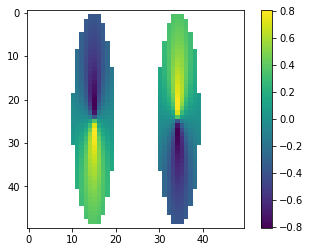

In [120]:
plt.imshow(potmesh_vtk_list2[0][:,24].T[::-1])
plt.colorbar()

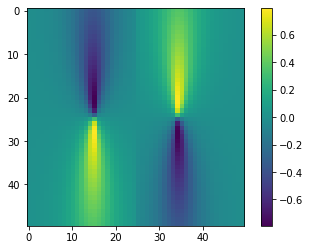

In [121]:
plt.imshow(tpot_cartlist2[0][:,24].T[::-1])
plt.colorbar()

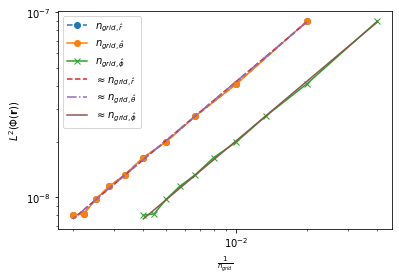

In [122]:
l2s2 = np.zeros((len(potmesh_vtk_list2),3))
for i in range(len(l2s2)):
    for j in range(l2s2.shape[1]):
        l2s2[i,j] = calc_l2_norm(field = potmesh_vtk_list2[i] - tpot_cartlist2[i])
expofit(ngx = ngridlist2[:,0], ngy = ngridlist2[:,1], ngz = ngridlist2[:,2], l2list = l2s2)